In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


### Importing necessary libraries

In [2]:
# Visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV

# Check for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm 

# Ignoring Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

print(df_train.shape)
print(df_test.shape)

(517754, 14)
(172585, 13)


In [4]:
df_train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
df_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


### Exploratory Data Analysis

In [6]:
df_train.columns

Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [8]:
df_train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [9]:
df_train.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [10]:
df_train['time_of_day'].unique()

array(['afternoon', 'evening', 'morning'], dtype=object)

In [11]:
df_train['weather'].unique()

array(['rainy', 'clear', 'foggy'], dtype=object)

In [12]:
df_train['lighting'].unique()

array(['daylight', 'dim', 'night'], dtype=object)

In [13]:
df_train['road_type'].unique()

array(['urban', 'rural', 'highway'], dtype=object)

### Data Visualization

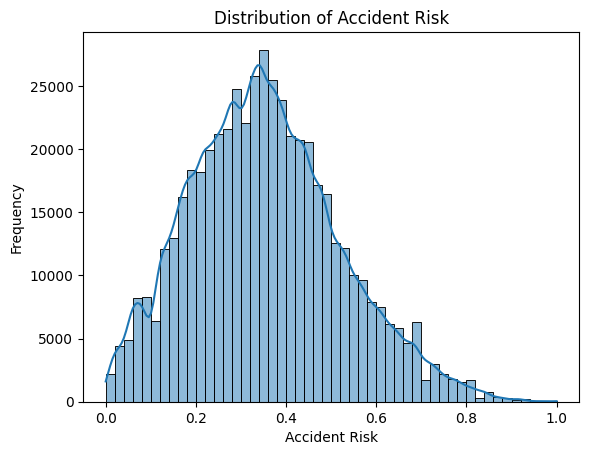

In [14]:
sns.histplot(df_train['accident_risk'], kde = True, bins = 50)
plt.xlabel('Accident Risk')
plt.ylabel('Frequency')
plt.title("Distribution of Accident Risk")
plt.show()

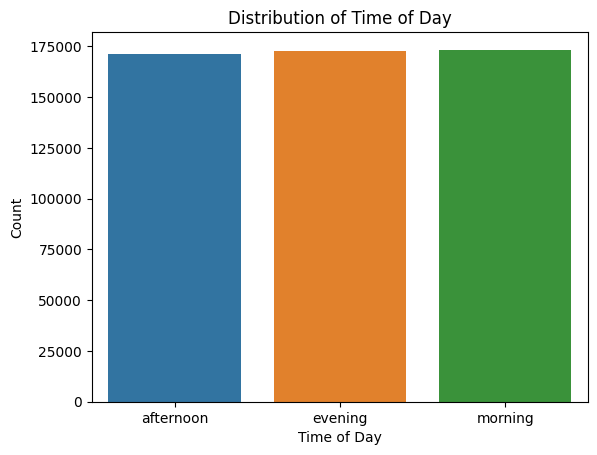

In [15]:
sns.countplot(x='time_of_day', data=df_train)
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Distribution of Time of Day')
plt.show()

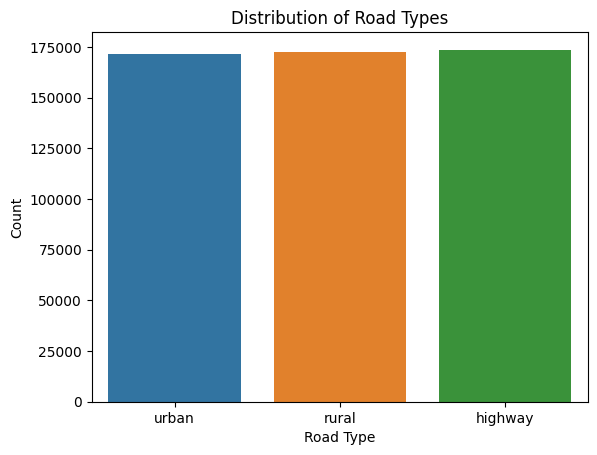

In [16]:
sns.countplot(x='road_type', data=df_train)
plt.title('Distribution of Road Types')
plt.xlabel('Road Type')
plt.ylabel('Count')
plt.show()

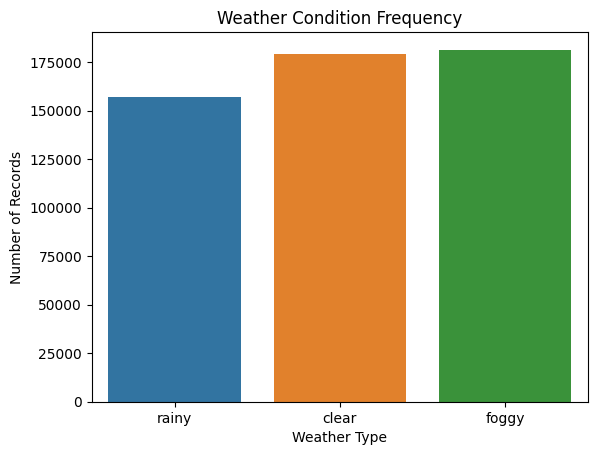

In [17]:
sns.countplot(x='weather', data=df_train)
plt.title('Weather Condition Frequency')
plt.xlabel('Weather Type')
plt.ylabel('Number of Records')
plt.show()

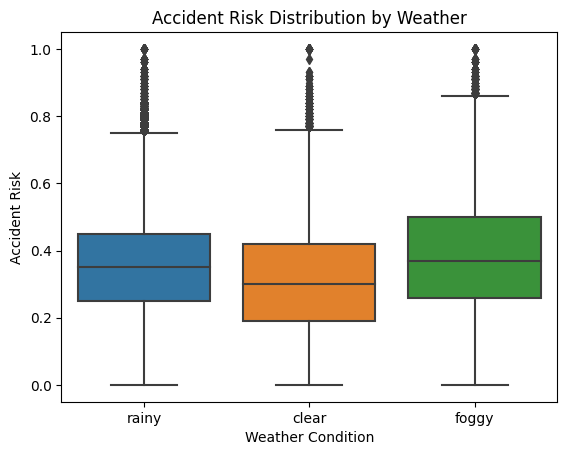

In [18]:
sns.boxplot(x='weather', y='accident_risk', data=df_train)
plt.title('Accident Risk Distribution by Weather')
plt.xlabel('Weather Condition')
plt.ylabel('Accident Risk')
plt.show()

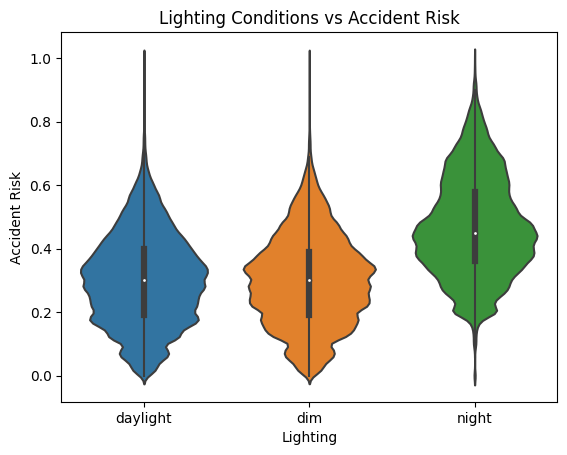

In [19]:
sns.violinplot(x='lighting', y='accident_risk', data=df_train)
plt.title('Lighting Conditions vs Accident Risk')
plt.xlabel('Lighting')
plt.ylabel('Accident Risk')
plt.show()

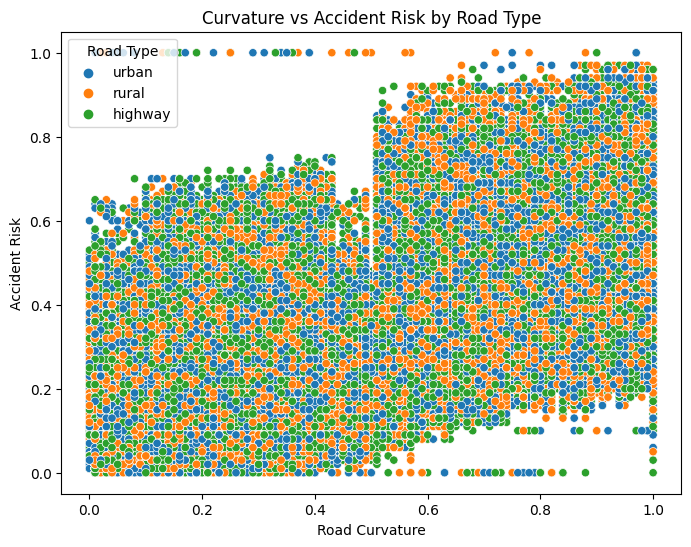

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='curvature', y='accident_risk', hue='road_type', data=df_train)
plt.title('Curvature vs Accident Risk by Road Type')
plt.xlabel('Road Curvature')
plt.ylabel('Accident Risk')
plt.legend(title='Road Type')
plt.show()

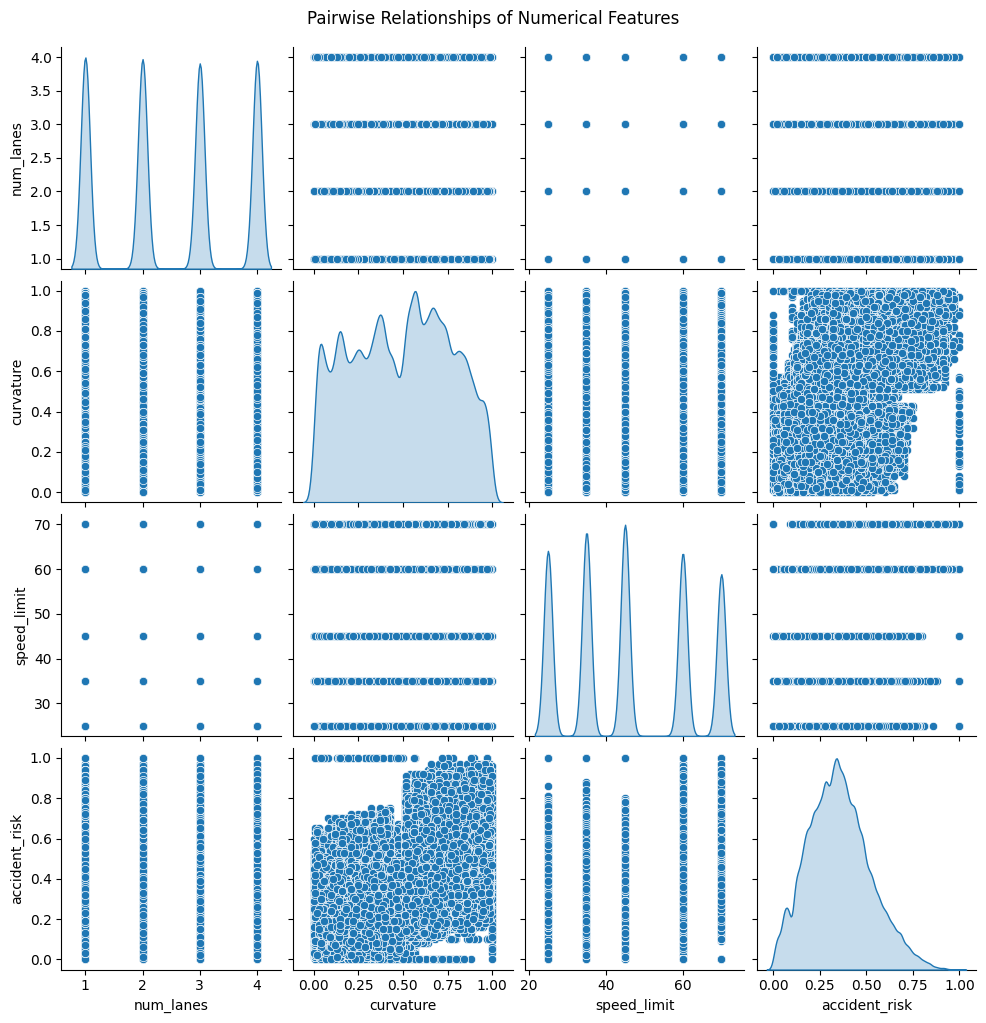

In [21]:
sns.pairplot(df_train[['num_lanes', 'curvature', 'speed_limit', 'accident_risk']], diag_kind='kde')
plt.suptitle('Pairwise Relationships of Numerical Features', y=1.02)
plt.show()

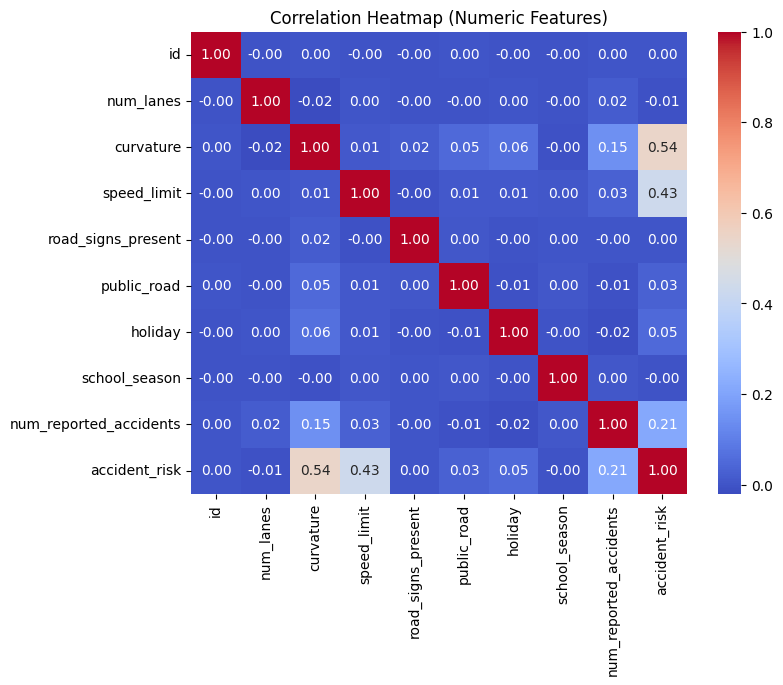

In [22]:
plt.figure(figsize=(8,6))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

In [23]:
train = df_train.copy()
test = df_test.copy()

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']

for col in bool_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

combined = pd.concat([train.drop(['accident_risk'], axis=1), test], axis=0)
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

X_train = combined.iloc[:len(train), :].copy()
X_test = combined.iloc[len(train):, :].copy()

y_train = train['accident_risk']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (517754, 17)
Test shape: (172585, 17)


In [24]:
X_train.head()

,id,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,time_of_day_evening,time_of_day_morning
0,0,2,0.06,35,0,1,0,1,1,False,True,False,False,False,True,False,False
1,1,4,0.99,35,1,0,1,1,0,False,True,False,False,False,False,True,False
2,2,4,0.63,70,0,1,1,0,2,True,False,True,False,False,False,False,True
3,3,4,0.07,35,1,1,0,0,1,False,False,True,False,False,True,False,True
4,4,1,0.58,60,0,0,1,0,1,True,False,False,False,True,False,True,False


### Feature Engineering

In [25]:
def clean_feature_engineering(df):

    df['road_stress_index'] = df['curvature'] * df['speed_limit']
    df['curvature_bin'] = pd.cut(df['curvature'], bins=[-0.01, 0.3, 0.6, 1.0], labels=['low','med','high'])
    df['speed_bin'] = pd.cut(df['speed_limit'], bins=[0, 35, 55, 1000], labels=['low','med','high'])
    df['lanes_bin'] = pd.cut(df['num_lanes'], bins=[0, 2, 3, 10], labels=['few','mid','many'])

    df['is_low_visibility'] = ((df['lighting'] != 'daylight') | (df['weather'] == 'foggy')).astype(int)
    df['is_high_risk_weather'] = df['weather'].isin(['rainy','foggy']).astype(int)
    df['is_school_rush_hour'] = ((df['school_season'] == 1) & (df['time_of_day'] == 'morning')).astype(int)

    df['urban_speed_ratio'] = df['speed_limit'] / (df['num_lanes'] + 1)
    df['rural_curve_risk'] = (df['road_type'] == 'rural').astype(int) * df['curvature']
    df['highway_curve_risk'] = (df['road_type'] == 'highway').astype(int) * df['curvature']
    return df

train = clean_feature_engineering(train)
test  = clean_feature_engineering(test)

In [26]:
cat_cols = [
    'road_type','lighting','weather','time_of_day',
    'curvature_bin','speed_bin','lanes_bin'
]

target = 'accident_risk'
y = train[target].copy()

train_X = train.drop(columns=[target])
test_X  = test.copy()

combined = pd.concat([train_X, test_X], axis=0, ignore_index=True)

combined_encoded = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

X_train = combined_encoded.iloc[:len(train_X), :].reset_index(drop=True)
X_test  = combined_encoded.iloc[len(train_X):, :].reset_index(drop=True)

print("Final shapes X_train:", X_train.shape, "X_test:", X_test.shape, "y:", y.shape)

missing_in_test = set(X_train.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train.columns)
print("Cols in train not in test:", len(missing_in_test))
print("Cols in test not in train:", len(missing_in_train))

Final shapes X_train: (517754, 30) X_test: (172585, 30) y: (517754,)
Cols in train not in test: 0
Cols in test not in train: 0


### Performing VIF Analysis to remove irrelavent features

In [27]:
X_vif = X_train.copy()

non_numeric = X_vif.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print("Dropping non-numeric columns before VIF:", list(non_numeric))
    X_vif = X_vif.drop(columns=non_numeric)

X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(0)
X_vif = X_vif.astype(float)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data.reset_index(drop=True, inplace=True)

vif_data.head(15)

Dropping non-numeric columns before VIF: ['road_type_rural', 'road_type_urban', 'lighting_dim', 'lighting_night', 'weather_foggy', 'weather_rainy', 'time_of_day_evening', 'time_of_day_morning', 'curvature_bin_med', 'curvature_bin_high', 'speed_bin_med', 'speed_bin_high', 'lanes_bin_mid', 'lanes_bin_many']


,Feature,VIF
0,speed_limit,87.639479
1,urban_speed_ratio,37.657917
2,curvature,27.415741
3,road_stress_index,26.799417
4,num_lanes,22.974934
5,is_low_visibility,4.491461
6,id,3.856738
7,is_high_risk_weather,2.966066
8,num_reported_accidents,2.797541
9,school_season,2.485490


In [28]:
drop_cols = [
    'is_high_risk_weather',
    'road_stress_index',
    'curvature_bin_med',
    'curvature_bin_high',
    'lanes_bin_many'
]

X_train_reduced = X_train.drop(columns=drop_cols)
X_test_reduced  = X_test.drop(columns=drop_cols)

print("Dropped redundant or collinear columns:", drop_cols)

Dropped redundant or collinear columns: ['is_high_risk_weather', 'road_stress_index', 'curvature_bin_med', 'curvature_bin_high', 'lanes_bin_many']


In [29]:
X_vif = X_train_reduced.copy().replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data.sort_values(by="VIF", ascending=False).head(15)

,Feature,VIF
3,speed_limit,159.913438
11,urban_speed_ratio,43.691549
1,num_lanes,25.996199
23,speed_bin_high,15.346351
9,is_low_visibility,14.971073
2,curvature,12.903319
12,rural_curve_risk,8.443569
13,highway_curve_risk,8.033668
15,road_type_urban,7.920652
14,road_type_rural,7.866966


In [30]:
drop_cols = [
    'is_high_risk_weather','road_stress_index',
    'curvature_bin_high', 'curvature_bin_med',
    'lanes_bin_many', 'is_low_visibility'
]

X_train_reduced = X_train.drop(columns=drop_cols)
X_test_reduced  = X_test.drop(columns=drop_cols)

print("Dropped columns:", drop_cols)
print("New shape:", X_train_reduced.shape)

Dropped columns: ['is_high_risk_weather', 'road_stress_index', 'curvature_bin_high', 'curvature_bin_med', 'lanes_bin_many', 'is_low_visibility']
New shape: (517754, 24)


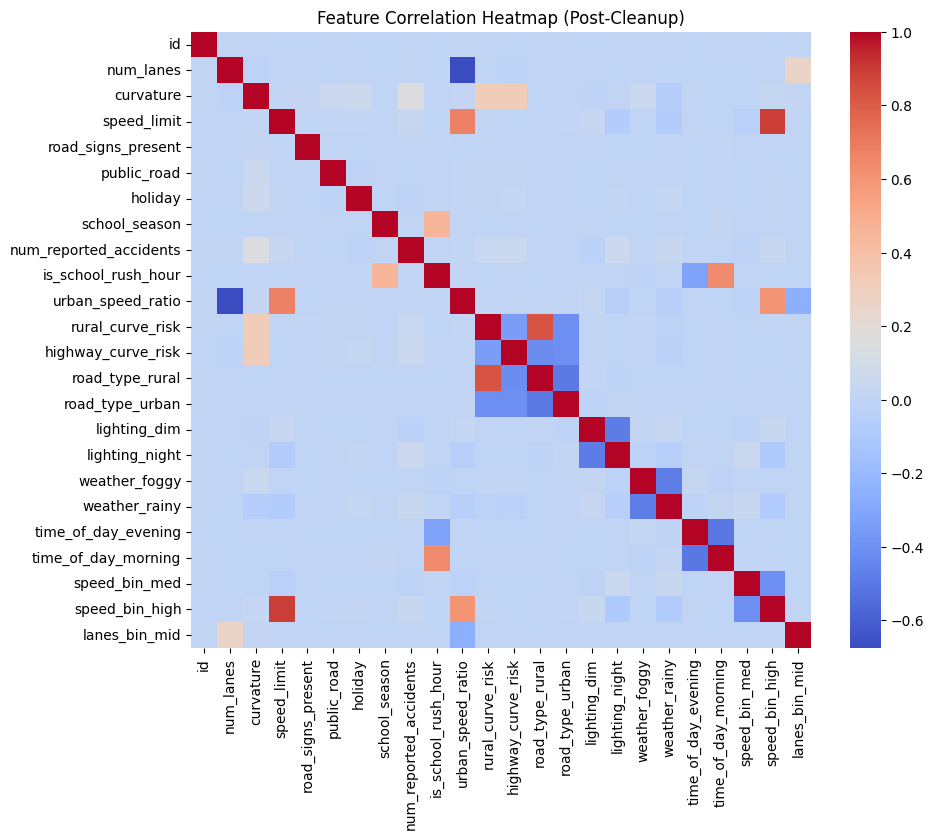

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_reduced.corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap (Post-Cleanup)")
plt.show()

### Splitting dataset into train and test

In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_reduced, y, test_size=0.2, random_state=42
)

print("Training shape:", X_tr.shape)
print("Validation shape:", X_val.shape)

Training shape: (414203, 24)
Validation shape: (103551, 24)


### Model Training and Evaluation

#### Linear Regression

In [33]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)

y_pred = lr.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Linear Regression Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Linear Regression Performance:
MAE: 0.0477
RMSE: 0.0614
R²: 0.8634


#### Important Features for Linear Regression

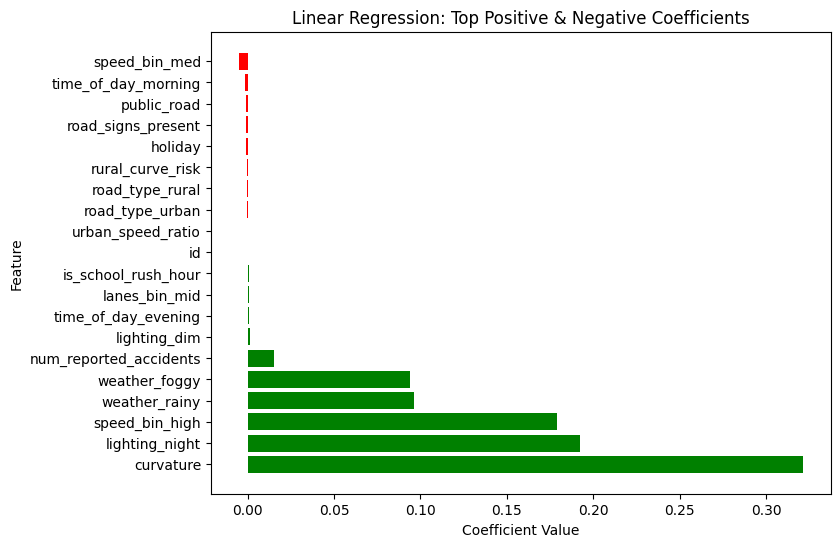

In [34]:
coef_df = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(8,6))
plt.barh(top_pos['Feature'], top_pos['Coefficient'], color='green')
plt.barh(top_neg['Feature'], top_neg['Coefficient'], color='red')
plt.title("Linear Regression: Top Positive & Negative Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

#### Random Forest

In [35]:
rf = RandomForestRegressor(
    n_estimators=100,      
    random_state=42,
    n_jobs=-1,   
    max_depth=None
)
rf.fit(X_tr, y_tr)

y_pred_rf = rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print(f"Random Forest Performance:")
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

Random Forest Performance:
MAE: 0.0451
RMSE: 0.0582
R²: 0.8773


#### Important Features for Random Forest

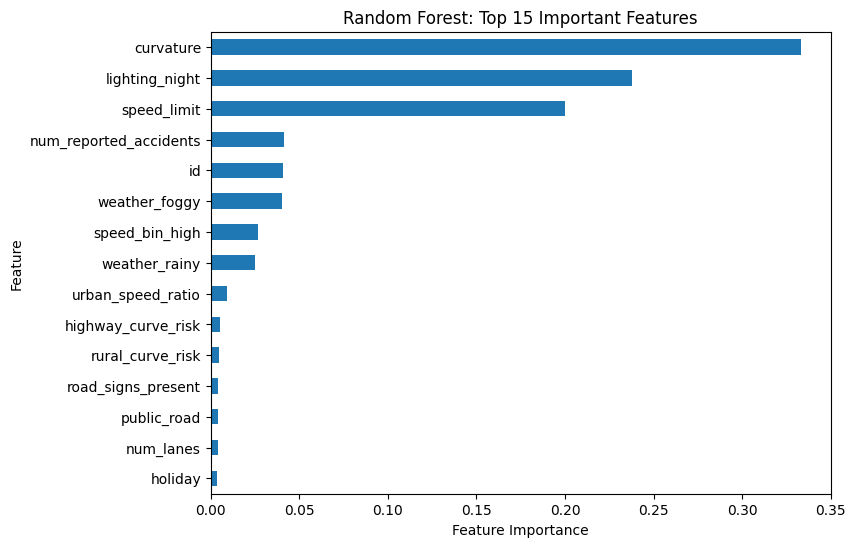

In [36]:
importances_rf = pd.Series(rf.feature_importances_, index=X_train_reduced.columns)
top_features_rf = importances_rf.nlargest(15)

plt.figure(figsize=(8,6))
top_features_rf.sort_values().plot(kind='barh')
plt.title('Random Forest: Top 15 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

#### XGBoost

In [37]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_tr, y_tr)
y_pred_xgb = xgb.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f"XGBoost Performance:")
print(f"MAE: {mae_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

XGBoost Performance:
MAE: 0.0438
RMSE: 0.0564
R²: 0.8848


#### Important Features for XGBoost

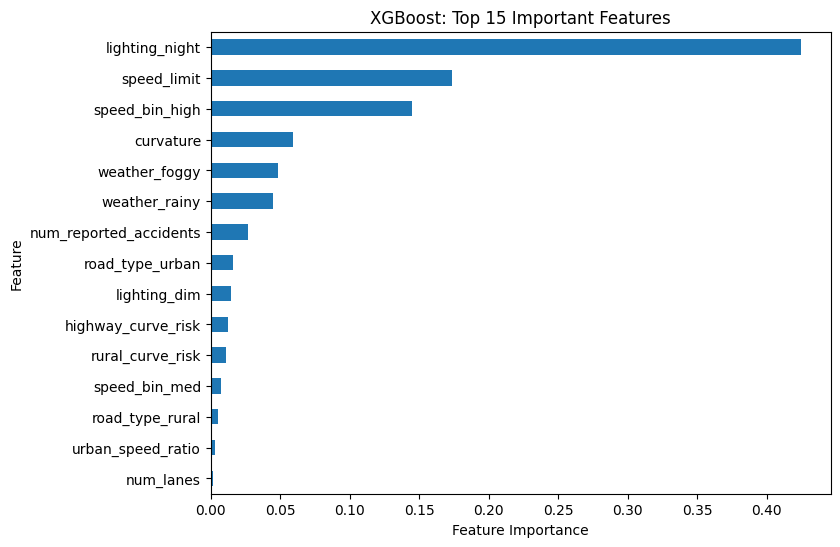

In [38]:
importances_xgb = pd.Series(xgb.feature_importances_, index=X_train_reduced.columns)
top_features_xgb = importances_xgb.nlargest(15)

plt.figure(figsize=(8,6))
top_features_xgb.sort_values().plot(kind='barh')
plt.title('XGBoost: Top 15 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

### Hypertuning model to find best parameters 

In [39]:
param_dist = {
    'n_estimators': [400, 600, 800],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    scoring='r2',
    n_iter=15,
    cv=3,
    verbose=1
)
search.fit(X_tr, y_tr)
print(search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'subsample': 1.0, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


### ROU-AUC Curve Analysis

AUC | LR: 0.9546  RF: 0.9573  XGB: 0.9603


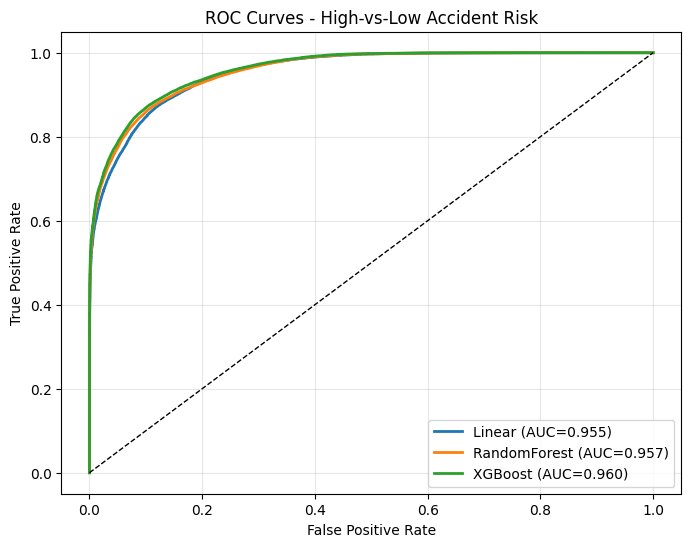

In [40]:
thr = np.median(y_val)
y_true_bin = (y_val >= thr).astype(int)

auc_lr = roc_auc_score(y_true_bin, y_pred)
auc_rf = roc_auc_score(y_true_bin, y_pred_rf)
auc_xgb = roc_auc_score(y_true_bin, y_pred_xgb)
print(f"AUC | LR: {auc_lr:.4f}  RF: {auc_rf:.4f}  XGB: {auc_xgb:.4f}")

fpr_lr, tpr_lr, _ = roc_curve(y_true_bin, y_pred)
fpr_rf, tpr_rf, _ = roc_curve(y_true_bin, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_true_bin, y_pred_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Linear (AUC={auc_lr:.3f})", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.3f})", lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})", lw=2)
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves - High-vs-Low Accident Risk")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()